
📍 Processing station: Badgerys_Creek_AWS


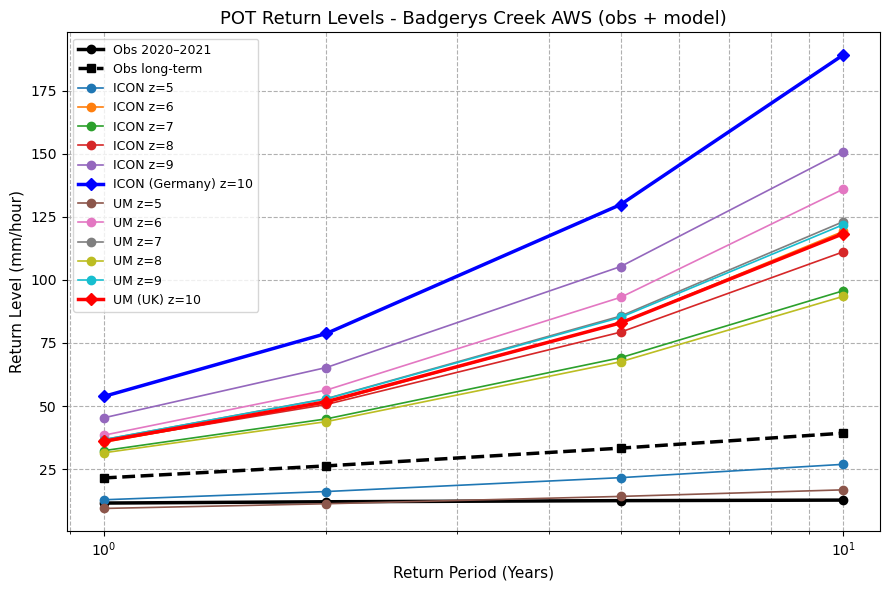


📍 Processing station: Richmond_RAAF


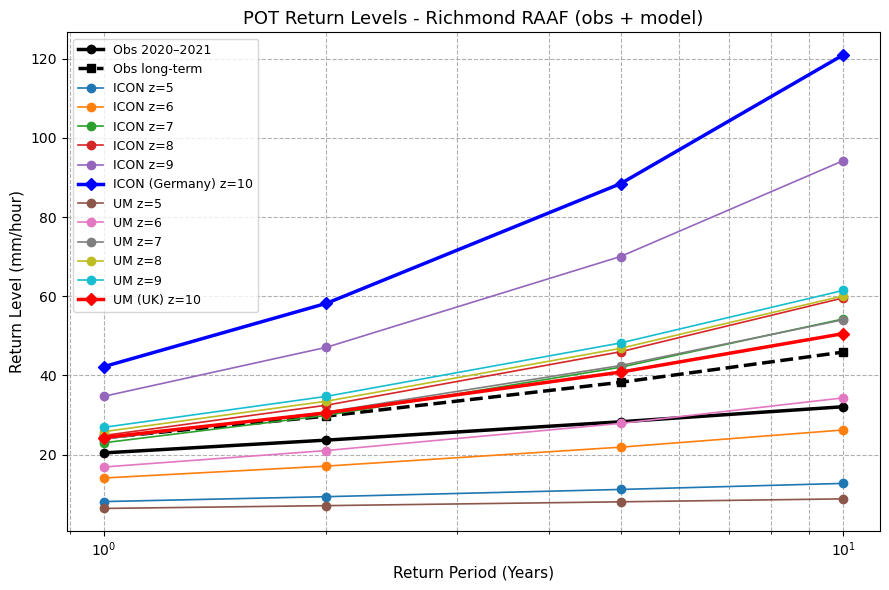


📍 Processing station: Bankstown_Airport_AWS


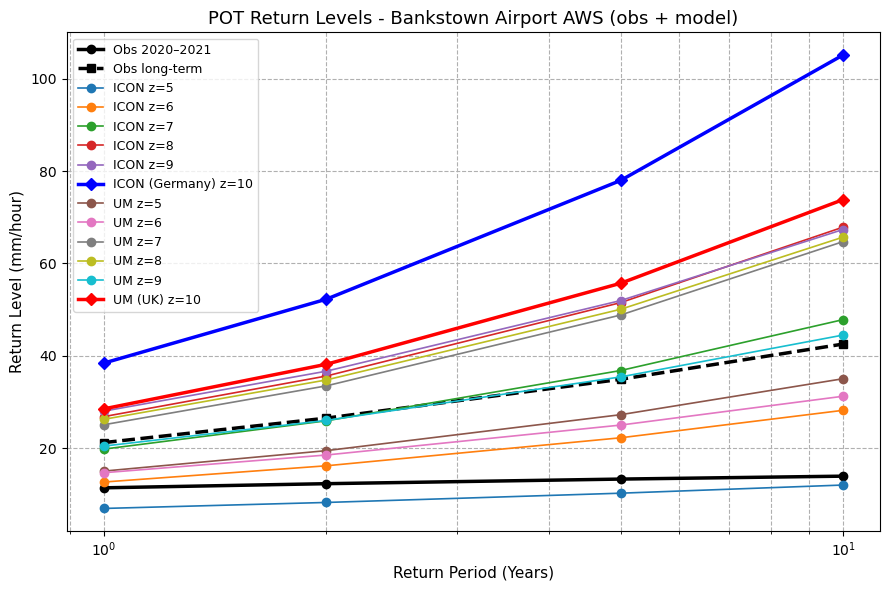


📍 Processing station: Sydney_Airport_AMO


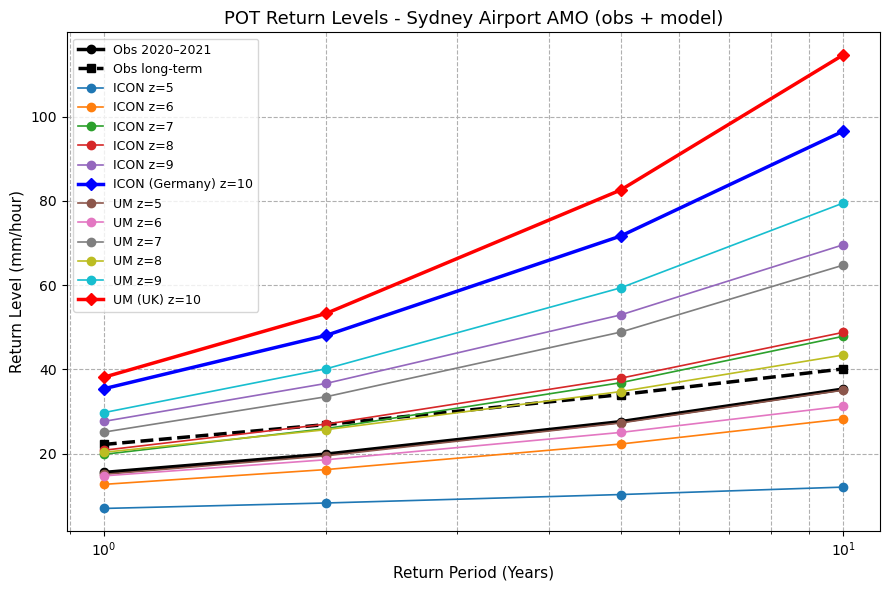


📍 Processing station: Norah_Head_AWS


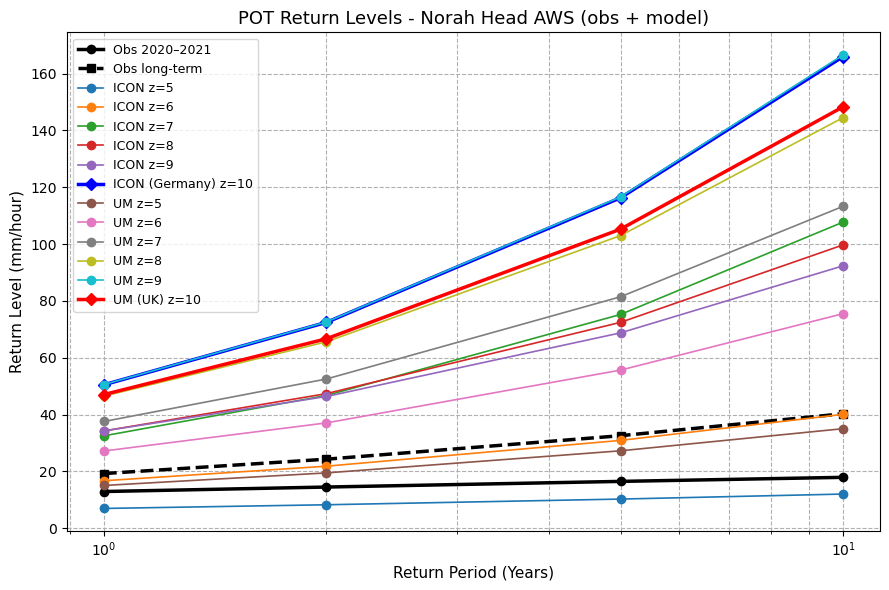

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import os

# === Setup ===
stations = {
    "badgery": "Badgerys_Creek_AWS",
    "richmond": "Richmond_RAAF",
    "bankstown": "Bankstown_Airport_AWS",
    "sydney": "Sydney_Airport_AMO",
    "norah": "Norah_Head_AWS",
}

zoom_levels = [5, 6, 7, 8, 9, 10]

models = {
    "ICON": {
        "prefix": "germany_node",
        "label": "ICON (Germany)",
        "color": "blue",
    },
    "UM": {
        "prefix": "uk_node",
        "label": "UM (UK)",
        "color": "red",
    }
}

base_obs_path = os.path.expanduser("~/hackathon/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney")
base_model_path = os.path.expanduser("~")
output_dir = os.path.expanduser("~/return_level_plots_combined")
os.makedirs(output_dir, exist_ok=True)

hours_per_year = 365.25 * 24
return_periods = np.array([1, 2, 5, 10])

def hours_between(start, end):
    return (end - start).total_seconds() / 3600

for obs_id, model_id in stations.items():
    print(f"\n📍 Processing station: {model_id}")

    obs_file = f"{base_obs_path}/{obs_id}_1h.csv"
    obs_df = pd.read_csv(obs_file, parse_dates=["Time"])
    obs_df = obs_df.rename(columns={"Time": "time", "Precipitation": "value"})
    obs_df['time'] = pd.to_datetime(obs_df['time'])

    short_df = obs_df.set_index('time').loc['2020-03':'2021-02'].reset_index()
    long_df = obs_df.copy()

    def compute_return_levels(df):
        df = df[df['value'] > 0.2]
        if df.empty:
            return None
        threshold = np.percentile(df['value'], 95)
        exc = df[df['value'] > threshold].copy()
        exc['excess'] = exc['value'] - threshold
        shape, loc, scale = genpareto.fit(exc['excess'], floc=0)
        total_hours = hours_between(df['time'].min(), df['time'].max())
        rate = len(exc) / total_hours
        return [threshold + genpareto.ppf(1 - 1 / (rate * T * hours_per_year), shape, loc=0, scale=scale)
                for T in return_periods]

    short_obs_rl = compute_return_levels(short_df)
    long_obs_rl = compute_return_levels(long_df)

    if short_obs_rl is None or long_obs_rl is None:
        print("⚠️ Observation data insufficient.")
        continue

    plt.figure(figsize=(9, 6))
    plt.plot(return_periods, short_obs_rl, color='black', marker='o', linestyle='-', linewidth=2.5, label='Obs 2020–2021')
    plt.plot(return_periods, long_obs_rl, color='black', marker='s', linestyle='--', linewidth=2.5, label='Obs long-term')

    for model_name, model_info in models.items():
        prefix = model_info["prefix"]
        label = model_info["label"]
        color = model_info["color"]

        for zoom in zoom_levels:
            model_file = f"{base_model_path}/{prefix}_{model_id}_z{zoom}.csv"
            if not os.path.exists(model_file):
                print(f"⛔ Missing model file: {model_file}")
                continue

            model_df = pd.read_csv(model_file, parse_dates=["time"])
            model_df = model_df[model_df['value'] > 0.2]
            threshold = np.percentile(short_df['value'], 95)
            mod_exc = model_df[model_df['value'] > threshold].copy()
            mod_exc['excess'] = mod_exc['value'] - threshold
            if len(mod_exc) < 20:
                print(f"⚠️ Not enough exceedances at zoom {zoom}. Skipping.")
                continue

            shape, loc, scale = genpareto.fit(mod_exc['excess'], floc=0)
            total_hours = hours_between(model_df['time'].min(), model_df['time'].max())
            rate = len(mod_exc) / total_hours
            rl = [threshold + genpareto.ppf(1 - 1 / (rate * T * hours_per_year), shape, loc=0, scale=scale)
                  for T in return_periods]

            plt.plot(return_periods, rl, marker='D' if zoom == 10 else 'o',
                     linestyle='-', color=color if zoom == 10 else None,
                     linewidth=2.5 if zoom == 10 else 1.2,
                     label=f"{label} z={zoom}" if zoom == 10 else f"{model_name} z={zoom}")

    plt.xscale('log')
    plt.xlabel('Return Period (Years)', fontsize=11)
    plt.ylabel('Return Level (mm/hour)', fontsize=11)
    plt.title(f'POT Return Levels - {model_id.replace("_", " ")} (obs + model)', fontsize=13)
    plt.grid(True, which="both", ls="--")
    plt.legend(fontsize=9)
    plt.tight_layout()
    filename = f"{output_dir}/return_levels_combined_{model_id}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


In [24]:
base_obs_path = "~/hackathon/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney"
base_model_path = "~/excel_exports"

hours_per_year = 365.25 * 24
return_periods = np.array([1, 2, 5, 10])

def hours_between(start, end):
    return (end - start).total_seconds() / 3600

for obs_id, model_id in stations.items():
    print(f"\n📍 Processing station: {model_id}")

    # === Load observation ===
    obs_file = os.path.expanduser(f"{base_obs_path}/{obs_id}_1h.csv")
    obs_df = pd.read_csv(obs_file, parse_dates=["Time"])
    obs_df = obs_df.rename(columns={"Time": "time", "Precipitation": "value"})
    obs_df['time'] = pd.to_datetime(obs_df['time'])  # Ensure it's datetime
    obs_df_lt = obs_df[obs_df['value'] > 0.2]
    print(f'mean:',obs_df_lt['value'].mean())
    print(f'max:',obs_df_lt['value'].max())


📍 Processing station: Badgerys_Creek_AWS
mean: 1.989189189189189
max: 57.2

📍 Processing station: Richmond_RAAF
mean: 2.1832560057737913
max: 47.0

📍 Processing station: Bankstown_Airport_AWS
mean: 1.9839044504478884
max: 54.4

📍 Processing station: Sydney_Airport_AMO
mean: 1.9930817610062892
max: 46.2

📍 Processing station: Norah_Head_AWS
mean: 1.8688720011920728
max: 72.8


In [22]:

base_obs_path = "~/hackathon/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney"
base_model_path = "~/excel_exports"

hours_per_year = 365.25 * 24
return_periods = np.array([1, 2, 5, 10])

def hours_between(start, end):
    return (end - start).total_seconds() / 3600

for obs_id, model_id in stations.items():
    print(f"\n📍 Processing station: {model_id}")

    # === Load observation ===
    obs_file = os.path.expanduser(f"{base_obs_path}/{obs_id}_1h.csv")
    obs_df = pd.read_csv(obs_file, parse_dates=["Time"])
    obs_df = obs_df.rename(columns={"Time": "time", "Precipitation": "value"})
    obs_df['time'] = pd.to_datetime(obs_df['time'])  # Ensure it's datetime
    obs_df = obs_df.set_index('time').loc['2020-03':'2021-02'].reset_index()
    obs_df_2020_2021 = obs_df[obs_df['value'] > 0.2]
    print(f'mean:',obs_df_2020_2021['value'].mean())
    print(f'max:',obs_df_2020_2021['value'].max())


📍 Processing station: Badgerys_Creek_AWS
mean: 1.7980392156862746
max: 12.2

📍 Processing station: Richmond_RAAF
mean: 2.0929159802306425
max: 27.6

📍 Processing station: Bankstown_Airport_AWS
mean: 1.6299319727891155
max: 13.2

📍 Processing station: Sydney_Airport_AMO
mean: 1.6217142857142859
max: 17.8

📍 Processing station: Norah_Head_AWS
mean: 1.5528662420382167
max: 14.2
